# Investigating Adaptive Chunk-based Composition in RNNs
In this project, we will investigate if gated-recurrent units (GRUs) can learn to reuse the common elements (e.g. sub-sequences) present across training examples by probing their hidden activity while they regenerate the original sequences. The final compilation of results can be found in this [presentation](https://docs.google.com/presentation/d/1AVO0R8dZ1R9ykwVeqA99lbB2LoenpcHXG6WBghcKy_s/edit?usp=sharing).
## 1. Training
We have 4 handwritten words (i.e. human action sequences) of 4 letters each in the training set — "well", "hell", "help", and "weld" — that the network will learn to reproduce. These words have more than one kind of common elements of different extents and at different positions, for example, "wel" or "hel" at the beginning, "el" in the middle, or "ell" at the end. We will later analyze if these shared chunks are invoked in the context (hidden) states while reproducing the respective target words using a small but sufficiently-sized network. Importantly, as a control in all cases, the network will begin from the same initial context and receive the target sequence (one-hot) encoding as a part of its input at each timestep.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch as th
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import multiprocessing
from joblib import Parallel, delayed

In [4]:
# load dataset: n_words (4), n_repeats, n_samples, 2 (x,y)
all_words = np.load('./data/all_words.npz')
# validate dataset
if len(all_words.keys()) > 1:
    keys = list(all_words.keys())
    # expected shape: (8, 75, 2)
    assert all([all_words[keys[0]].shape == all_words[keys[i]].shape for i in range(1, len(keys))])
# create a batch dataset along with one-hot encodings
seq_ys = []
seq_stgts = []
for widx, w in enumerate(all_words.keys()):
    y = th.from_numpy(all_words[w]).float() # n_repeats, n_samples, 2
    stgt = th.zeros(y.shape[0], len(all_words.keys())) # n_repeats, n_words
    stgt[:, widx] = 1.0
    seq_ys.append(y)
    seq_stgts.append(stgt)
# total_seqs = n_repeats * n_words = batch_size
ys = th.cat(seq_ys, dim=0) # total_seqs, n_samples, 2
stgts = th.cat(seq_stgts, dim=0) # total_seqs, n_words
# dataset (no shuffling necessary; full grad-desc)
data = DataLoader(TensorDataset(ys, stgts), batch_size=ys.shape[0])

As its output at each timestep, the network will produce an action in the visual space, i.e. change in position ($\mathbf{u}_t$), and receive as input the one-hot encoded target sequence ($\mathbf{s}_\text{tgt}$) in concatenation with the true global position at the previous timestep (during teacher-forcing) or the cumulative sum of previous actions (during fine-tuning), mimicking instantaneous visual feedback in both cases. The loss at each step will be the L2 distance between the true sequence position at that time and the network's output action applied to the network's position input ($\mathbf{p}_{t-1}$). To achieve accurate long-horizon predictions — such as reproducing human handwriting — we first simplify training by using teacher forcing, where the network learns output dependencies from true inputs. Afterwards, we fine-tune its parameters $\Omega$ by feeding the network's own outputs back as a part of the position input at the next timestep. Below, we lay out the same mathematically.
$$\begin{align*}
\mathbf{u}_t &\coloneqq \begin{bmatrix}\Delta p_x \quad \Delta p_y\end{bmatrix} = \text{Network}(\mathbf{x}_{t-1} \mid \Omega_{t-1}), \quad t \geq 1\\
\mathbf{x}_t &\coloneqq \begin{bmatrix}\mathbf{s}_\text{tgt}, \quad \mathbf{p}_t\end{bmatrix}\\
\mathbf{p}_t &= \begin{cases}
\text{zero} & t = 0\\
\widehat{\mathbf{y}}_t & \text{if fine-tune and } t \geq 1\\
\mathbf{y}_t & \text{otherwise for } t \geq 1
\end{cases}\\
\widehat{\mathbf{y}}_t &= \begin{cases}
\mathbf{u}_t + \mathbf{p}_{t-1} & \text{in general}\\
\displaystyle \sum_{1 \leq \tau \leq t} \mathbf{u}_\tau & \text{reduced form in pure fine-tuning}
\end{cases}\\
E_t &= ||\mathbf{y}_t - (\mathbf{u}_t+\mathbf{p}_{t-1})||^2, \quad t \geq 1\\
\end{align*}$$

Due to the long prediction horizon in this task, we will train the network by 1) gradually increasing prediction length from $T=$ 30 to 40 and 50, then to 60, and finally 74 steps, and by 2) simultaneously increasing the fine-tuning ratio at each stage starting from 0, to 0.25 and 0.5, then to 0.75, and finally 1. During the course of training the network, the number of epochs will also be adapted, starting from 1000 epochs for the first stage and gradually increasing to 6000 epochs for the final stage.

**Note:** for stages where the fine-tuning ratio is neither 0 (pure teacher-forcing) nor 1 (pure fine-tuning), to determine whether the true sequence position (teacher-forcing) or summed action (fine-tuning) is provided as the input position at each timestep, the network will sample from a Bernoulli distribution parameterized by the respective fine-tuning expectation. This information during the forward pass is then appropriately accounted for during backpropagation through time.

Finally, the accuracy of the network at any instant during training will be estimated by calculating the mean loss (i.e. mean of deviation errors at each timestep) over the entire prediction length given a fixed set of parameters, 
$$E_\text{mean} = \frac{1}{T}\sum_{1 \leq t \leq T} E_t(\Omega).$$


In [5]:
class Network(nn.Module):
    """
    gru with 1 hidden layer and a fully connected output layer with softsign activation (f(x) = x/(1 + |x|))
    input: one-hot encoded target word context vector (stgt) concatenated with 2D global position (p_{t-1})
    output: action (u_t) at the current timestep producing a change in position, so that yhat_t = u_t + p_{t-1}
    note: the network's initial hidden state (h0) is not trained and is set to zero by default for all sequences
    """
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device):
        super().__init__()
        self.device = device
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = 1
        self.gru = nn.GRU(input_dim, hidden_dim, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softsign = nn.Softsign()
        self._init_params()
        self.to(device)

    def _init_params(self):
        for name, param in self.named_parameters():
            if name == "gru.weight_ih_l0":
                nn.init.xavier_uniform_(param)
            elif name == "gru.weight_hh_l0":
                nn.init.orthogonal_(param)
            elif name == "gru.bias_ih_l0":
                nn.init.zeros_(param)
            elif name == "gru.bias_hh_l0":
                nn.init.zeros_(param)
            elif name == "fc.weight":
                nn.init.xavier_uniform_(param)
            elif name == "fc.bias":
                nn.init.zeros_(param)
            else:
                raise ValueError(f"Parameter {name} not initialized")

    def forward(self, xprev: th.Tensor, hprev: th.Tensor = None):
        """
        forward propagation for a single timestep
        input: xprev (batch_size, input_dim), hprev (n_layers, batch_size, hidden_dim)
        output: u (batch_size, output_dim), h (n_layers, batch_size, hidden_dim)
        """
        xprev = xprev.unsqueeze(1) # resize to (batch_size, 1, input_dim)
        z, h = self.gru(xprev, hprev)
        u = self.softsign(self.fc(z.squeeze(1)))
        return u, h

    def generate(self, stgt: th.Tensor, T: int):
        """
        forward propagation over next T timesteps in pure fine-tuning mode (closing the input-output loop)
        input: stgt = one-hot-encoding of the target word (batch_size, n_words), T = the number of timesteps to generate
        output: tensor of generated positions (batch_size, T+1, output_dim); returned in numpy format on the cpu
        """
        self.eval()
        batch_size = stgt.shape[0]
        stgt = stgt.to(self.device)
        # init hidden state
        ht = th.zeros(self.n_layers, batch_size, self.hidden_dim, device=self.device)
        pt = th.zeros(batch_size, self.output_dim, device=self.device)
        pts = [pt.clone().unsqueeze(1)] # list of tensors (batch_size, 1, output_dim)
        # forward propagation
        with th.no_grad():
            for _ in range(T):
                xt = th.cat((stgt, pt), dim=1)
                ut, ht = self.forward(xt, ht)
                pt += ut
                pts.append(pt.clone().unsqueeze(1))
        return th.cat(pts, dim=1).cpu().numpy()

    def forward_train(self, ys: th.Tensor, stgts: th.Tensor, T: int, ft_ratio: float = 0.0):
        """
        forward propagation with teacher-forcing/fine-tuning chosen randomly using ft_ratio for each of T timesteps
        input: ys = ground-truth positions (batch_size, n_samples, output_dim), stgt = one-hot-encoding of the target 
                words in the batch (batch_size, n_words), and T = prediction horizon
        output: positions over timesteps 0 to T (batch_size, T+1, output_dim)
        """
        batch_size = ys.shape[0]
        ht = th.zeros(self.n_layers, batch_size, self.hidden_dim, device=self.device)
        pt = ys[:, 0, :] # start with true initial position
        yhats = [pt.clone().unsqueeze(1)]
        use_ft = th.bernoulli(th.full((batch_size, T), ft_ratio)).bool().to(device=self.device) # Bernoulli mask
        # forward propagation
        for t in range(1, T+1):
            xt = th.cat((stgts, pt), dim=1)
            ut, ht = self.forward(xt, ht)
            pt += ut
            yhats.append(pt.clone().unsqueeze(1))
            pt = th.where(use_ft[:, t-1].unsqueeze(1), pt, ys[:, t, :])
        return th.cat(yhats, dim=1)

In [6]:
def train(model, data, optimizer, loss_fn, T_stages, ft_ratios, epoch_stages, device):
    """
    trains the network using a progressively using a curriculum (or staged) strategy;
    returns a trained model and a stage-wise list of loss histories
    """
    assert len(T_stages) == len(ft_ratios) == len(epoch_stages)
    assert all(x <= 1.0 for x in ft_ratios) and all(x >= 0.0 for x in ft_ratios)
    model.train()
    loss_hist = []

    # staged training
    for s in range(len(T_stages)):
        T = T_stages[s]
        ft_ratio = ft_ratios[s]
        epochs = epoch_stages[s]
        stage_loss = np.zeros(epochs, float)
        print(f"Training stage {s+1}/{len(T_stages)}: T={T}, ft_ratio={ft_ratio}, epochs={epochs}")
        for epoch in range(epochs):
            for ys, stgts in data:
                ys = ys.to(device)
                stgts = stgts.to(device)
                optimizer.zero_grad()
                yhats = model.forward_train(ys, stgts, T, ft_ratio)
                loss = loss_fn(yhats[:, 1:, :], ys[:, 1:T+1, :])
                loss.backward() # bptt
                th.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
                optimizer.step()
                stage_loss[epoch] += loss.item() / len(data)
            if epoch == 0 or (epoch+1) % 250 == 0:
                print(f"Epoch {epoch+1}/{epochs}: loss = {stage_loss[epoch]:.6f}")
        loss_hist.append(stage_loss)
    
    model.eval()
    return model, loss_hist

In [ ]:
# dimension setup
device = th.device("cpu")
output_dim = 2 # 2D position
input_dim = len(all_words.keys()) + output_dim # one-hot encoding + position
hidden_dims = [32, 28, 24, 20, 16, 8, 4, 3, 2, 1] # hidden layer sizes

# create models and optimizers
models = {}
optimizers = {}
for h in hidden_dims:
    model_name = f"model{h}"
    models[model_name] = Network(input_dim, h, output_dim, device)
    optimizers[model_name] = optim.Adam(models[model_name].parameters(), lr=1e-3)
    globals()[model_name] = models[model_name]

# training setup
loss_fn = nn.MSELoss() # loss function
T_stages = [30, 40, 50, 60, 74] # prediction horizon
ft_ratios = [0.0, 0.25, 0.5, 0.75, 1.0] # fine-tuning ratios
epoch_stages = [1000, 1500, 2500, 4000, 6000] # epochs per stage

# training
n_cpus = multiprocessing.cpu_count()
result = Parallel(n_jobs=n_cpus)(
        delayed(train)(model, data, optimizer, loss_fn, T_stages, ft_ratios, epoch_stages, device)
        for model, optimizer in zip(models.values(), optimizers.values())
)

# update models and store loss histories
losses = {}
for model, loss_hist in result:
    model_name = f"model{model.hidden_dim}"
    models[model_name] = model
    globals()[model_name] = model
    losses[model_name] = loss_hist

In [80]:
# plot performance of each model
def plot_all_words_perf(model , n_words, T):
    """
    generates each of the n_words sequence using the trained model and plots the results
    """
    s_tgt = th.eye(n_words) # one-hot encodings of target sequences (words)
    yhats = model.generate(s_tgt, T) # generate the sequences
    fig, axs = plt.subplots(n_words, 1, figsize=(5, 5), sharex=True, sharey=True)
    if n_words == 1:  # if only one subplot, make it iterable
        axes = [axes]

    for i in range(n_words):
        seq = yhats[i]
        axs[i].plot(seq[:, 0], seq[:, 1], linestyle='-', marker='o', markersize=2)
        axs[i].set_title(f"Word {i+1}", fontsize=12)
        axs[i].set_aspect('equal', adjustable='box')

    fig.suptitle(f"{model.hidden_dim} Hidden Units", fontsize=16)
    plt.xlim(-0.05, 1.15)
    plt.tight_layout()
    plt.show()

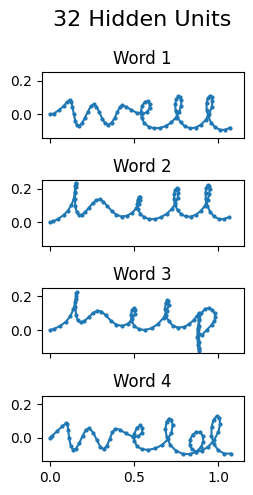

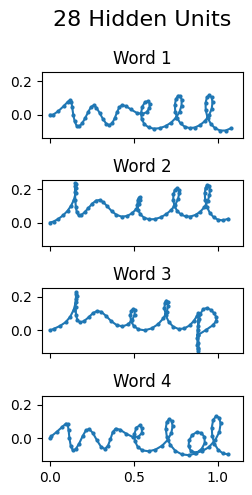

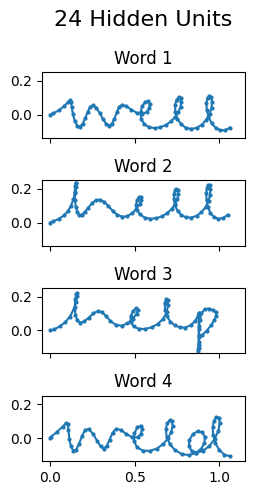

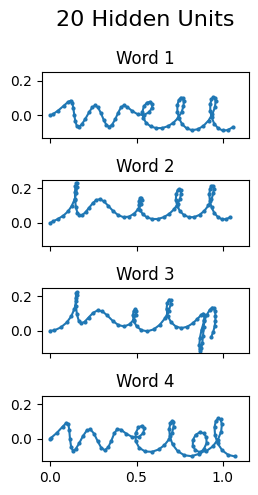

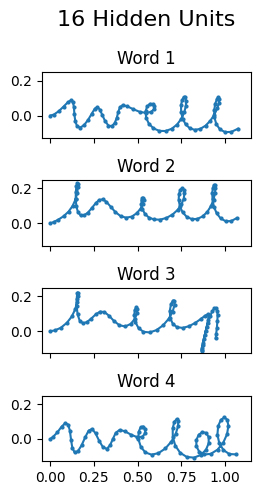

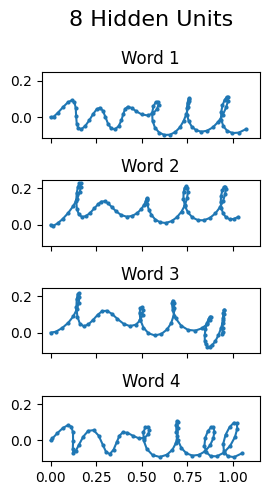

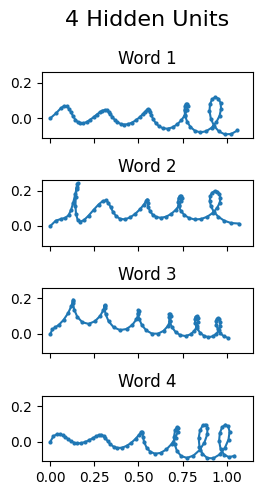

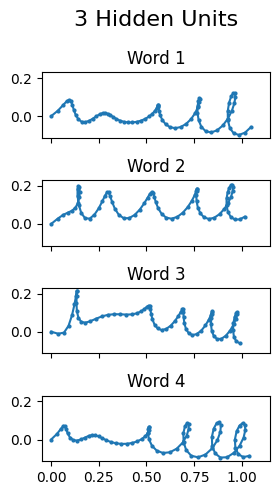

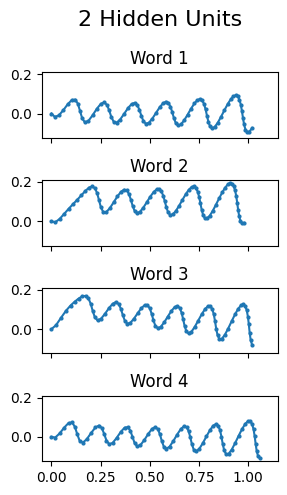

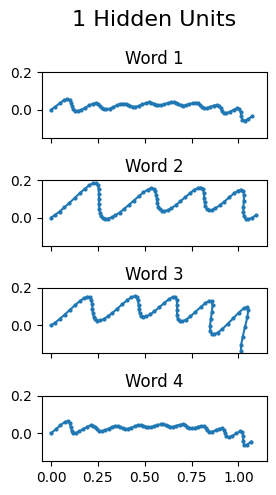

In [83]:
for model in models.values():
    plot_all_words_perf(model, 4, 74) # complete sequence

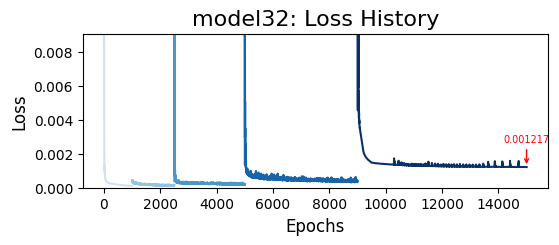

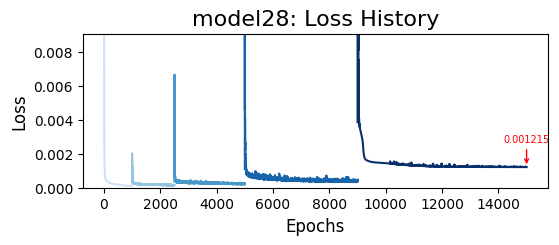

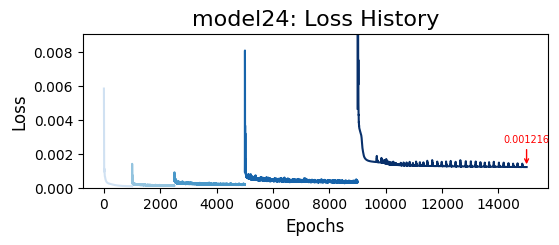

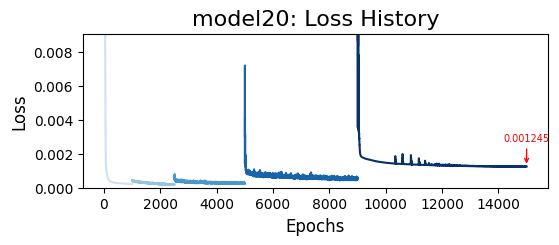

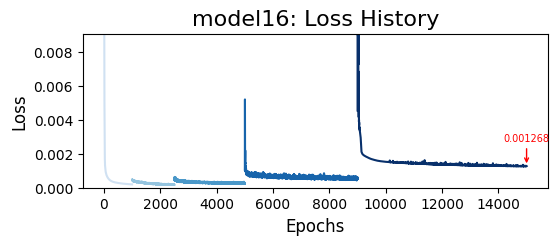

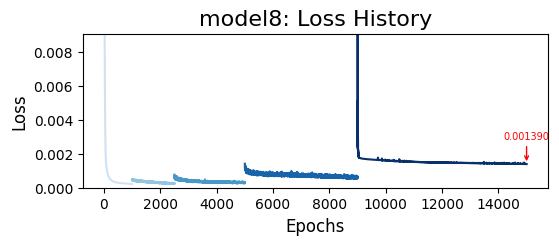

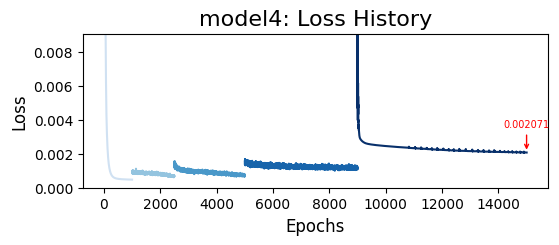

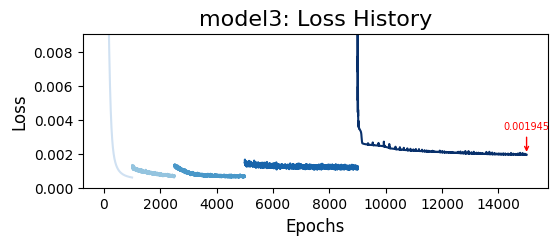

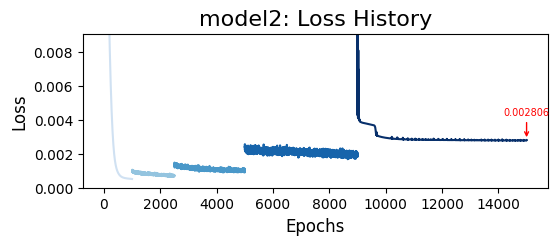

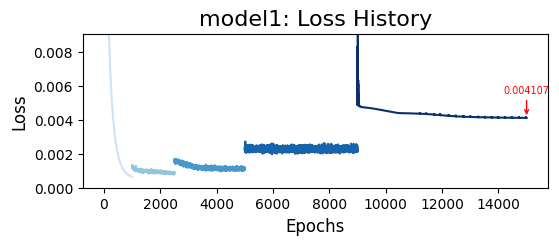

In [84]:
# plot losses with final loss annotation
def plot_loss(losses, final_window=5):
    # compute the average starting loss over all stages for all models
    avg_start_loss = np.mean(
        [stage_loss[0] for loss_hist in losses.values() for stage_loss in loss_hist]
    )
    for model_name, loss_hist in losses.items():
        fig, ax = plt.subplots(figsize=(6, 2))
        epoch_offset = 0
        n_stages = len(loss_hist)
        cmap = plt.get_cmap("Blues")
        # plot each training stage
        for s, stage_loss in enumerate(loss_hist):
            epochs = np.arange(epoch_offset, epoch_offset + len(stage_loss))
            color = cmap((s + 1) / n_stages)
            ax.plot(epochs, stage_loss, color=color)
            # for the final stage, store epochs and losses for the annotation
            if s == n_stages - 1:
                final_stage_epochs = epochs
                final_stage_loss = stage_loss
            epoch_offset += len(stage_loss)
        ax.set_xlabel("Epochs", fontsize=12)
        ax.set_ylabel("Loss", fontsize=12)
        ax.set_title(f"{model_name}: Loss History", fontsize=16)
        ax.set_ylim(0, 1.1 * avg_start_loss)
        
        # compute average of the last 'final_window' epochs in the final stage
        window = final_window if len(final_stage_loss) >= final_window else len(final_stage_loss)
        x_highlight = np.mean(final_stage_epochs[-window:])
        y_highlight = np.mean(final_stage_loss[-window:])
        # annotate with the final loss value
        ax.annotate(
            f"{y_highlight:.6f}",
            xy=(x_highlight, y_highlight),
            xytext=(x_highlight, y_highlight + 0.2 * avg_start_loss),
            fontsize=7,
            color='red',
            ha='center',
            va='center',
            arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->')
        )
        plt.show()

plot_loss(losses)

In [8]:
# save the trained models and training losses
def save_object(obj, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump(obj, f)

for m in models.values():
    # assumes 'losses' dictionary to exist with a key for each model
    save_object(m, f"./models/hidden{m.hidden_dim}.pkl")
    save_object(losses[f"model{m.hidden_dim}"], f"./models/hidden{m.hidden_dim}_loss.pkl")

In [82]:
# load the trained models and training losses
def load_object(save_path):
    with open(save_path, "rb") as f:
        obj = pickle.load(f)
    return obj

models = {}
losses = {}
for h in [32, 28, 24, 20, 16, 8, 4, 3, 2, 1]:
    model_name = f"model{h}"
    models[model_name] = load_object(f"./models/hidden{h}.pkl")
    globals()[model_name] = models[f"model{h}"]
    losses[model_name] = load_object(f"./models/hidden{h}_loss.pkl")

## 2. Analysis
Let's go!

In [ ]:
# dPCA or targeted dimensionality reduction techniques